# War fatalities in Russia in 2022 estimated via excess male mortality
## External deaths by gender

In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

plt.style.use("mpl_style.txt")

In [2]:
df_external = pd.read_excel('../external-deaths-by-gender-year/external-deaths.xlsx', skiprows=1)

df_external

,Unnamed: 0,Мужчины и женщины,Мужчины,Женщины
0,2000,318716,250009,68707
1,2001,331634,259109,72525
2,2002,339296,264055,75241
3,2003,335173,260323,74850
4,2004,327123,254109,73014
5,2005,315915,246257,69658
6,2006,282785,219216,63569
7,2007,259412,201334,58078
8,2008,244463,189552,54911
9,2009,224576,173089,51487


In [3]:
male = df_external.values[:,2]
female = df_external.values[:,3]

years = np.arange(2000, 2023)

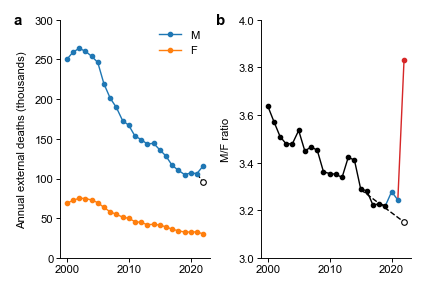

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(3, 2))

axs[0].plot(years, male / 1000, '.-', label='M')
axs[0].plot(years, female / 1000, '.-', label='F')
axs[0].set_ylim([0, 300])
axs[0].set_ylabel('Annual external deaths (thousands)')
axs[0].legend()

ratio = male / female

axs[1].plot(years[:-3], ratio[:-3], 'k.-')
axs[1].plot(years[-4:-1], ratio[-4:-1], '-', color='tab:blue', zorder=-1)
axs[1].plot(years[-3:-1], ratio[-3:-1], '.', color='tab:blue')
axs[1].plot(years[-2:], ratio[-2:], '-', color='tab:red', zorder=-1)
axs[1].plot(years[-1], ratio[-1], '.', color='tab:red', clip_on=False)

axs[1].set_ylim([3, 4])
axs[1].set_ylabel(r'M/F ratio')

# Do computations
x = np.arange(2015, 2023)
LinReg = LinearRegression()
LinReg.fit(x[-8:-3].reshape(-1,1), ratio[-8:-3].reshape(-1,1))
yhat = LinReg.predict(x[-8:].reshape(-1,1))
baseline = yhat[-1,0] * female[-1] / 1000

axs[0].plot(x[-2:], [male[-2]/1000, baseline], '--', color='k', zorder=-2)
axs[0].plot(x[-1], baseline, 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)

axs[1].plot(x[-8:], yhat, '--', color='k', zorder=-2)
axs[1].plot(x[-1], yhat[-1], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)

fig.text(.005, .95, 'a', fontsize=8, weight='bold')
fig.text(.505, .95, 'b', fontsize=8, weight='bold')

fig.savefig('figures/external-gender.png')
fig.savefig('figures/external-gender.pdf')

In [5]:
for fit_length in [5, 10]:
    x = years
    beg = fit_length + 3

    # Perform the linear fit and extrapolate
    LinReg.fit(x[-beg:-3].reshape(-1,1), ratio[-beg:-3].reshape(-1,1))
    yhat_sklearn = LinReg.predict(x[-beg:].reshape(-1,1))
    excess = male[-1] - yhat_sklearn[-1][0] * female[-1]

    # Compute the uncertainty
    X = np.concatenate((x[-beg:].reshape(-1,1), np.ones((beg,1))), axis=1)
    y = ratio[-beg:].reshape(-1,1)
    beta = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3]) @ X[-beg:-3].T @ y[-beg:-3]
    yhat = X[-beg:] @ beta
    sigma2 = np.sum((y[-beg:-3] - yhat[-beg:-3])**2) / (y.size - 2) # sigma^2 = MSE/(n-p)
    S = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3])
    predictive_var = sigma2 * X[-1:] @ S @ X[-1:].T + sigma2
    predictive_std = np.sqrt(predictive_var[0][0]) 
    excess_std = predictive_std * female[-1]

    assert(np.allclose(yhat, yhat_sklearn))

    print(f'Excess (based on {fit_length:2}-year trend): {excess:.0f} +- {excess_std:.0f}')

Excess (based on  5-year trend): 20562 +- 767
Excess (based on 10-year trend): 20095 +- 1727
